# Google Landmark Recognition Challenge 2020
Simplified image similarity ranking and re-ranking implementation with:
* EfficientNetB0 backbone for global feature similarity search
* DELF module for local feature reranking

Reference papers:
* 2020 Recognition challenge winner: https://arxiv.org/abs/2010.01650
* 2019 Recognition challenge 2nd place: https://arxiv.org/abs/1906.03990

In [2]:
!nvidia-smi

Sun Apr 10 05:50:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Importing libraries
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from scipy import spatial
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
# Directories and file paths
TRAIN_DIR = '../input/landmark-recognition-2020/train'
TRAIN_CSV = '../input/landmark-recognition-2020/train.csv'
train_df = pd.read_csv(TRAIN_CSV)

TRAIN_PATHS = [os.path.join(TRAIN_DIR, f'{img[0]}/{img[1]}/{img[2]}/{img}.jpg') for img in train_df['id']]
train_df['path'] = TRAIN_PATHS

train_df

,id,landmark_id,path
0,17660ef415d37059,1,../input/landmark-recognition-2020/train/1/7/6...
1,92b6290d571448f6,1,../input/landmark-recognition-2020/train/9/2/b...
2,cd41bf948edc0340,1,../input/landmark-recognition-2020/train/c/d/4...
3,fb09f1e98c6d2f70,1,../input/landmark-recognition-2020/train/f/b/0...
4,25c9dfc7ea69838d,7,../input/landmark-recognition-2020/train/2/5/c...
...,...,...,...
1580465,72c3b1c367e3d559,203092,../input/landmark-recognition-2020/train/7/2/c...
1580466,7a6a2d9ea92684a6,203092,../input/landmark-recognition-2020/train/7/a/6...
1580467,9401fad4c497e1f9,203092,../input/landmark-recognition-2020/train/9/4/0...
1580468,aacc960c9a228b5f,203092,../input/landmark-recognition-2020/train/a/a/c...


In [6]:
# Subsetting
train_df_grouped = pd.DataFrame(train_df.landmark_id.value_counts())
train_df_grouped.reset_index(inplace=True)
train_df_grouped.columns = ['landmark_id','count']

# Selected landmarks based on inclass frequency
selected_landmarks = train_df_grouped[(train_df_grouped['count'] <= 155) & (train_df_grouped['count'] >= 150)]

train_df_sub = train_df[train_df['landmark_id'].isin(selected_landmarks['landmark_id'])]
new_id = []
current_id = 0
previous_id = int(train_df_sub.head(1)['landmark_id'])
for landmark_id in train_df_sub['landmark_id']:
    if landmark_id == previous_id:
        new_id.append(current_id)
    else:
        current_id += 1
        new_id.append(current_id)
        previous_id = landmark_id

train_df_sub['new_id'] = new_id

NUM_CLASSES = train_df_sub['landmark_id'].nunique()

print(f"Unique classes found: {NUM_CLASSES}")
train_df_sub

Unique classes found: 75


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,landmark_id,path,new_id
29015,02c51ed68361a297,3732,../input/landmark-recognition-2020/train/0/2/c...,0
29016,03a2f5d6e09cbed7,3732,../input/landmark-recognition-2020/train/0/3/a...,0
29017,0426ea625fbd6ed9,3732,../input/landmark-recognition-2020/train/0/4/2...,0
29018,08eb745bfb37e253,3732,../input/landmark-recognition-2020/train/0/8/e...,0
29019,0b227d6fdd934242,3732,../input/landmark-recognition-2020/train/0/b/2...,0
...,...,...,...,...
1579088,f35afd4659346c53,202892,../input/landmark-recognition-2020/train/f/3/5...,74
1579089,f44dc951556233f6,202892,../input/landmark-recognition-2020/train/f/4/4...,74
1579090,f5284d5f8941f37b,202892,../input/landmark-recognition-2020/train/f/5/2...,74
1579091,faae6afd4d0d3f08,202892,../input/landmark-recognition-2020/train/f/a/a...,74


In [7]:
# Training and validation splits
# 90/10 stratified split for training and validation
X_train, X_val, y_train, y_val = train_test_split(train_df_sub[['id', 'path']], train_df_sub['new_id'],
                                                  train_size = 0.9,
                                                  random_state = 123,
                                                  shuffle = True,
                                                  stratify = train_df_sub['new_id'])

# Held-out test set for inference
# Further 95/5 split -> 5% of original training set left for test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                   train_size = 0.95,
                                                   random_state = 123,
                                                   shuffle = True,
                                                   stratify = y_train)

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == train_df_sub.shape[0]

print(f"Training data shape: {X_train.shape}")
print(f"Training label shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation label shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test label shape: {y_test.shape}")

Training data shape: (9779, 2)
Training label shape: (9779,)
Validation data shape: (1144, 2)
Validation label shape: (1144,)
Test data shape: (515, 2)
Test label shape: (515,)


In [8]:
print(f"Unique classes on y_train: {y_train.nunique()}")
print(f"Unique classes on y_val: {y_val.nunique()}")
print(f"Unique classes on y_test: {y_test.nunique()}")

Unique classes on y_train: 75
Unique classes on y_val: 75
Unique classes on y_test: 75


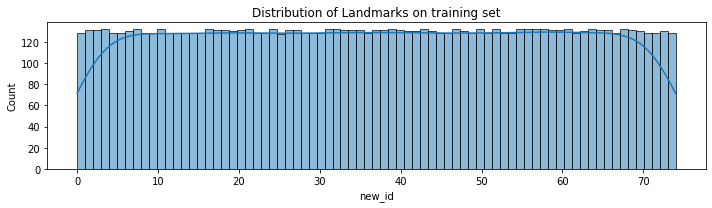

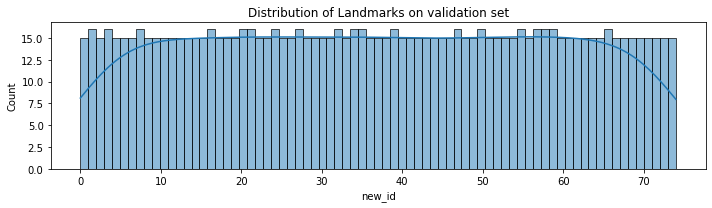

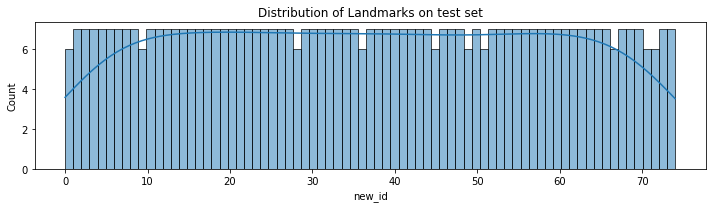

In [9]:
# Classes distribution on training, validation and test sets
plt.figure(figsize = (10, 3))
ax = sns.histplot(y_train, bins=75, kde = True)
ax.set_title('Distribution of Landmarks on training set')
plt.tight_layout()

plt.figure(figsize = (10, 3))
ax = sns.histplot(y_val, bins=75, kde = True)
ax.set_title('Distribution of Landmarks on validation set')
plt.tight_layout()

plt.figure(figsize = (10, 3))
ax = sns.histplot(y_test, bins=75, kde = True)
ax.set_title('Distribution of Landmarks on test set')
plt.tight_layout()
plt.show()

In [10]:
!rm -r train_sub, test_sub, val_sub && ls

rm: cannot remove 'train_sub,': No such file or directory
rm: cannot remove 'test_sub,': No such file or directory
rm: cannot remove 'val_sub': No such file or directory


In [11]:
# Creating image directories for classes subset
NEW_BASE_DIR = "/kaggle/working"

# Training set directory
for file, path, landmark in tqdm(zip(X_train['id'], X_train['path'], y_train)):
    dir = f"{NEW_BASE_DIR}/train_sub/{str(landmark)}"
    os.makedirs(dir, exist_ok = True)
    fname = f"{file}.jpg"
    shutil.copyfile(src = path, dst = f"{dir}/{fname}")

# Validation set directory    
for file, path, landmark in tqdm(zip(X_val['id'], X_val['path'], y_val)):
    dir = f"{NEW_BASE_DIR}/val_sub/{str(landmark)}"
    os.makedirs(dir, exist_ok = True)
    fname = f"{file}.jpg"
    shutil.copyfile(src = path, dst = f"{dir}/{fname}")

# Training set directory
for file, path, landmark in tqdm(zip(X_test['id'], X_test['path'], y_test)):
    dir = f"{NEW_BASE_DIR}/test_sub/{str(landmark)}"
    os.makedirs(dir, exist_ok = True)
    fname = f"{file}.jpg"
    shutil.copyfile(src = path, dst = f"{dir}/{fname}")

9779it [01:24, 115.78it/s]
1144it [00:09, 122.38it/s]
515it [00:04, 127.26it/s]


In [12]:
!ls

__notebook_source__.ipynb  test_sub  train_sub	val_sub


In [13]:
!cd train_sub && ls

0   12	16  2	23  27	30  34	38  41	45  49	52  56	6   63	67  70	74
1   13	17  20	24  28	31  35	39  42	46  5	53  57	60  64	68  71	8
10  14	18  21	25  29	32  36	4   43	47  50	54  58	61  65	69  72	9
11  15	19  22	26  3	33  37	40  44	48  51	55  59	62  66	7   73


In [15]:
# Creating tensorflow tf.data.Dataset
from tensorflow.keras.utils import image_dataset_from_directory

IMG_SIZE = 224
BATCH_SIZE = 16

print("Building training dataset...")
# Training tf.data.Dataset
train_ds = image_dataset_from_directory(f"{NEW_BASE_DIR}/train_sub",
                                        label_mode = 'int',
                                        shuffle = True,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE)

print("Building validation dataset...")
# Validation tf.data.Dataset
val_ds = image_dataset_from_directory(f"{NEW_BASE_DIR}/val_sub",
                                        label_mode = 'int',
                                        shuffle = True,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE)

print("Building test dataset...")
# Test tf.data.Dataset
test_ds = image_dataset_from_directory(f"{NEW_BASE_DIR}/test_sub",
                                        label_mode = 'int',
                                        shuffle = True,
                                        image_size = (IMG_SIZE, IMG_SIZE),
                                        batch_size = BATCH_SIZE)

Building training dataset...
Found 9779 files belonging to 75 classes.
Building validation dataset...
Found 1144 files belonging to 75 classes.
Building test dataset...
Found 515 files belonging to 75 classes.


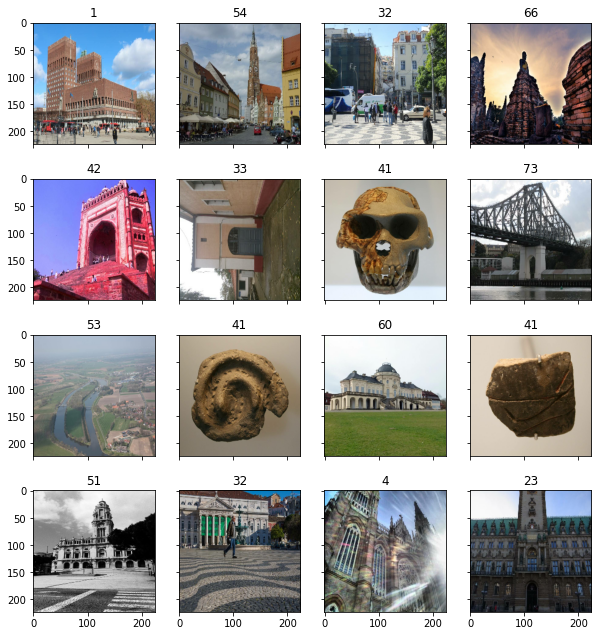

In [17]:
# Visualizing a random batch from training dataset
for data_batch, labels_batch in train_ds.take(1):
    ncols = 4
    nrows = int(data_batch.shape[0]/ncols)
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10, 11),
                           sharex = True, sharey = True)
    img_counter = 0
    for image, label in zip(data_batch, labels_batch):
        axi = ax.flat[img_counter]
        axi.imshow(image/255.)
        label = label.numpy()
#         axi.set_title(np.where(label == 1)[0])
        axi.set_title(label)
        img_counter += 1
plt.show()

In [ ]:
####### ALTERNATIVE CODE FOR UNBATCHED DATASET #######
# ncols = 4
# nrows = 4
# fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize=(10, 11),
#                        sharex = True, sharey = True)
# img_counter = 0
# for image, label in train_ds.take(16):
#     axi = ax.flat[img_counter]
#     axi.imshow(image[0]/255.)
#     label = label.numpy()
# #         axi.set_title(np.where(label == 1)[0])
#     axi.set_title(label)
#     img_counter += 1
# plt.show()

In [18]:
# Defining a data augmentation stage
img_augmentation = tf.keras.Sequential(
    # [layers.RandomFlip("horizontal"),
    [layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
     layers.RandomRotation(0.02),
     layers.RandomZoom(0.2)],
     name = "img_augmentation",
)

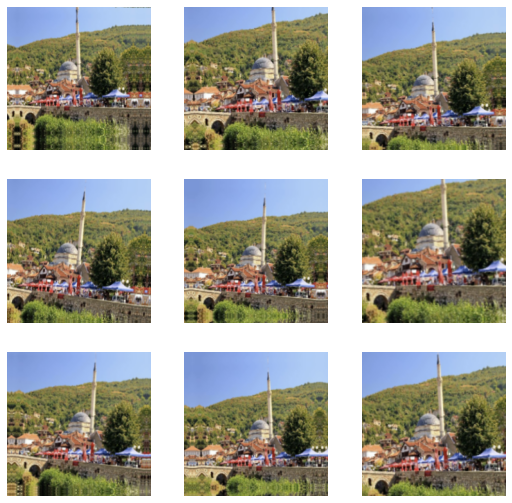

In [19]:
# Displaying variations of a randomly augmented training image
plt.figure(figsize=(9, 9))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = img_augmentation(image, training = True)
        plt.imshow(augmented_image[15].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
####### ALTERNATIVE CODE FOR UNBATCHED DATASET #######
# # Displaying variations of a randomly augmented training image
# plt.figure(figsize=(9, 9))
# for image, label in train_ds.take(16):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = img_augmentation(image[0], training = True)
#         plt.imshow(augmented_image.numpy().astype("uint8"))
#         plt.axis("off")